In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Solve gpu issue for pytorch
# https://discuss.pytorch.org/t/pytorch-1-8-0-fasterrcnn-resnet50-fpn-error/114150/11

In [3]:
import numpy as np
import cv2
import os
import re

# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

/home/yizhou/miniconda3/envs/rlgpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
from dataset import HandleDataset, get_train_transform, collate_fn

In [7]:
train_dataset = HandleDataset("/home/yizhou/Research/temp/", num_frames = 5, \
                              transforms = get_train_transform()) #

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

100%|████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 641.61it/s]


In [9]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [10]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


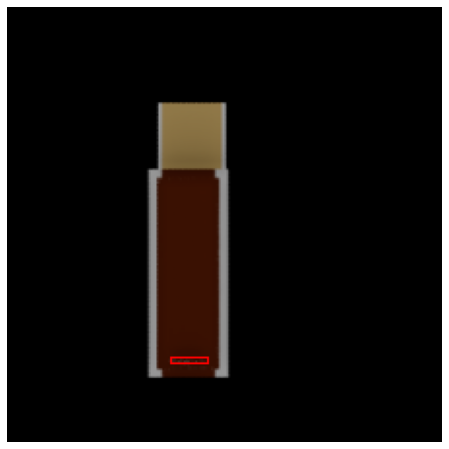

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [12]:
len(train_dataset)

874

# Model

In [13]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [14]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [15]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# Train

In [18]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [21]:
num_epochs = 20

from tqdm.auto import tqdm

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    print("epoch", epoch)
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # if itr % 50 == 0:
        #     print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

epoch 0


 23%|█████████████▏                                            | 50/219 [00:12<00:42,  3.99it/s]

Iteration #50 loss: 0.5045431864771255


 46%|██████████████████████████                               | 100/219 [00:24<00:27,  4.27it/s]

Iteration #100 loss: 0.1789407149933183


 68%|███████████████████████████████████████                  | 150/219 [00:36<00:16,  4.12it/s]

Iteration #150 loss: 0.21298549195674135


 91%|████████████████████████████████████████████████████     | 200/219 [00:48<00:04,  4.13it/s]

Iteration #200 loss: 0.2299786168349417


100%|█████████████████████████████████████████████████████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch #0 loss: 0.29169939179690585
epoch 1


 14%|████████▏                                                 | 31/219 [00:07<00:44,  4.20it/s]

Iteration #250 loss: 0.343188374292855


 37%|█████████████████████▍                                    | 81/219 [00:19<00:33,  4.11it/s]

Iteration #300 loss: 0.34243943913501335


 43%|████████████████████████▉                                 | 94/219 [00:22<00:29,  4.21it/s]